# Adaptive Stochastic Gradient Descent

Implementation and comparison of adaptive stochastic gradient descent methods using Python programming language. The efficiency comparison is demonstrated in the logistic regression optimization problem.

## Introduction

**Gradient descent** is one of the most popular numerical methods for solving modern optimization problems: from cost reduction to neural networks training. The thing that all these problems have in common is an aim to describe it as a mathematical model (e.g. mathematical equation) $J(\theta_{i})$, which has a set of independent parameters $\theta_{i}$, and then find specific values of $\theta_{i}$ so $J(\theta_{i})$ will reach the minimum possible value. As an example, in neural network training $J(\theta_{i})$ can be described as a loss between the expected training example and the actual one, where $\theta_{i}$ will be the **weight coefficients** of the neural network. So the goal of the training process is to find the optimal value of **weight coefficients**, so the loss will become minimum and the output value of a neural network will become as close to expected as possible.

By definition, the **gradient** is a vector that points towards the highest  increase of the function value $F$ in high dimensional space $R^{n}$, that can be interpreted as a vector of partial derivatives with respect to each parameter $x_{1}, ..., x_{n}$ of the function $F$ in the specific point $a$:

$\nabla F(a) = \begin{bmatrix}
\frac{\partial f}{\partial x_{1}} (a) \\
\vdots \\
\frac{\partial f}{\partial x_{n}} (a) \\
\end{bmatrix}$

Various optimization algorithms, which are based on **gradient descent**, have common feature: usage of a vector, opposite to the gradient value (antigradient or $- \nabla F$), as the key direction to the function minimum.

### Overviewed algorithms

- Batch gradient descent
- Stochastic gradient descent
- Mini-batch gradient descent
- Nesterov AG
- ADAGRAD
- RMSPROP
- ADAM

### Tensorflow API usage

**Gradient values** calculation will be speeded up for overviewed methods using [computation graphs](https://www.tensorflow.org/api_docs/python/tf/Graph) from [TensorFlow framework API](https://github.com/tensorflow/tensorflow).

In [1]:
import tensorflow as tf

Tensorflow framework provides class [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape) with a set of methods for required computations: [gradient()](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) and [jacobian()](https://www.tensorflow.org/api_docs/python/tf/GradientTape#jacobian). The following section contains examples of gradient computations:

In [2]:
# Defining the scope of gradient computation. Here all defined variables
# will be registered in Tensorflow calculation graph.
with tf.GradientTape(persistent=True) as grad:
  x, y = (tf.Variable(2.0), tf.Variable(-1.0))

  # Single variable equation
  f = x ** 3 + 2 * x ** 2 + 12 * x + 100

  # Multiple variable equation
  F = x ** 2 + x * y + y ** 2

# f'(x) = 3 * x ** 2 + 4 * x + 12, f'(2.0) = 32.0
df = grad.gradient(f, x)

# dFdx = 2 * x + y, dFdx(2.0, -1.0) = 3.0
# dFdy = x + 2 * y, dFdy(2.0, -1.0) = 0.0
[dFdx, dFdy] = grad.gradient(F, [x, y])

# Release graph allocated memory
del grad

print(f'Single variable equation:\nf\'(2.0) = {df};\n')
print(f'Multiple variable equation:\ndFdx(2.0, -1.0) = {dFdx};\ndFdy(2.0, -1.0) = {dFdy};')

Single variable equation:
f'(2.0) = 32.0;

Multiple variable equation:
dFdx(2.0, -1.0) = 3.0;
dFdy(2.0, -1.0) = 0.0;


### Tensor operations

All tensor-like structure wrappers and operation methods for them are used from [Numpy](https://github.com/numpy/numpy) package.

In [3]:
import numpy as np

### Algorithm convergence visualisation

Iterations of the each **gradient descent** algorithm can be plotted as the path on 3D surface, in case model has only 2 independent parameters $\{ \theta_{1}, \theta_{2} \}$ so they can represent $X$ and $Y$ axises, and remaining $Z$ axis represents value of estimation equation to optimize $J(\theta_{1}, \theta_{2})$. All visualisation tools are used from [matplotlib](https://github.com/matplotlib/matplotlib) package.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import matplotlib.cm as colormaps
from matplotlib import rcParams, cycler

To plot the projection of the 3D surface of $J(\theta_{i})$ will be used a custom procedure.

In [5]:
from typing import Callable


def plot_grid(F: Callable[[np.array, np.array], np.array],
              X: np.array, Y: np.array,
              elev=30, azim=50, ax=None):
  """
  Plots 3D surface grid for 2 independent
  parameters and estimation equation
  :param F: estimation equation
  :param X: first independent parameter
  :param Y: second independent parameter
  :param elev: vertical rotation angle
  :param azim: horizontal rotation angle
  :param ax: predefined plotting axis
  :return: generated plotting axis
  """

  # Generating grid
  x, y = np.meshgrid(X, Y)

  # If grid plotting axis is not defined above,
  # the new one will be created
  if ax is None:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(elev=elev, azim=azim)

  # Plotting grid
  surf = ax.plot_surface(x, y, F(x, y), 
                         cmap=colormaps.coolwarm, 
                         antialiased=True)
  fig.colorbar(surf)

  # For axis reusability purposes
  return ax

### Optimization problem

**Logistic regression** is chosen as an example of an optimization problem for comparing the convergence rate of the **gradient descent** algorithms. This mathematical model can be described as a binary classifier, which outputs a probability value of a certain set of features $x_{i}$ to belong to a certain class (e. g. **true** or **false**). Using the definition of optimization problem from above, the classifier can be represented in the form of two components: **an adder** that combines all the characteristics into a single one: $z_{j} = \sum_{i=1}^{n} \theta_{i} x_{i, j}$ (or $z_{j} = \theta^{T} \cdot x$), and **a converter** that calculates the probability of the characteristics belonging to a certain class based on the output value of **an adder**: $g(a) = \frac{1}{1 + e^{-a}}$.

In [6]:
# Adder component
Z = lambda theta, x: tf.transpose(theta) @ x

# Converter component
G = lambda a: 1.0 / (1.0 + tf.exp(-a))

Classification test cases:

In [7]:
# x = (0, 0), theta = (1, 1) => g = 0.5
tf.assert_equal(G(Z(tf.constant([[1.0], [1.0]]),
                    tf.constant([[0.0], [0.0]]))),
                tf.constant([[0.5]]))

# x = (1, 0), theta = (1, 1) => g = 0.7310586
tf.assert_equal(G(Z(tf.constant([[1.0], [1.0]]),
                    tf.constant([[1.0], [0.0]]))),
                tf.constant([[0.7310586]]))

# x = (0, -1), theta = (1, 1) => g = 0.26894143
tf.assert_equal(G(Z(tf.constant([[1.0], [1.0]]),
                    tf.constant([[0.0], [-1.0]]))),
                tf.constant([[0.26894143]]))

# x = (0.5, -1), theta = (2, -1.5) => g = 0.9241418
tf.assert_equal(G(Z(tf.constant([[2.0], [-1.5]]),
                    tf.constant([[0.5], [-1.0]]))),
                tf.constant([[0.9241418]]))

The solution to the problem is to find optimal $\theta_{i}$ so for input features $x_{i}$ the **loss** $J(\theta_{i})$ between output value of classifier $\hat{y_{j}} = g(z_{\theta}(x_{i, j}))$ and expected value $y_{j}$ will be minimal.

The set of classes, mentioned above, can be represented as $\{ 0, 1 \}$, e. g. if model output is $1$ - features belong to the class, and if $0$ - features do not belong to the class. In this case, the rule of the fitting regression model can be interpreted as follows: *if expected output is $y=1$, the loss should approach $0$ when model output approaches $1$ and grow to infinity when model output approaches $0$. For the case $y=0$ these conditions apply vise versa.*

Model fitting rule or **loss function** can expressed as limits:

$\begin{cases}
\lim_{g(z_{\theta}(x_{i, j})) \to 1} J_{j}(\theta_{i}) = 0, & \lim_{g(z_{\theta}(x_{i, j})) \to 0} J_{j}(\theta_{i}) = \infty, & y=1 \\
\lim_{g(z_{\theta}(x_{i, j})) \to 0} J_{j}(\theta_{i}) = 0, & \lim_{g(z_{\theta}(x_{i, j})) \to 1} J_{j}(\theta_{i}) = \infty, & y=0
\end{cases}$

Limitation conditions fit the $\log(x)$ function, so the **loss function** can be expressed as the following system:

$ J_{j}(g, y) = \begin{cases}
-\log(g), & y = 1  \\
-\log(1 - g), & y = 0
\end{cases}$

The statement can be joined into a single formula: $ J_{j}(g, y) = - y \log(g) - (1 - y) \log(1 - g) $ - this formula is appliable for single pair of features and output. For multiple pairs loss value can be calculated as the mean of losses for single pairs: $ J(g, y) = \frac{1}{m} \sum_{j=1}^{m} J_{j}(g, y) = \frac{1}{m} \sum_{j=1}^{m} ( - y \log(g) - (1 - y) \log(1 - g) ) = -\frac{1}{m} \sum_{j=1}^{m} (y \log(g) + (1 - y) \log(1 - g) )$

In [8]:
# Loss function
J = lambda g, y: - y * tf.math.log(g) - (1 - y) * tf.math.log(1 - g)

As the result, the derived fitting rule (**loss function**) is a convex function with only one minimum for each output class $ \{ 0, 1 \} $. This can be demonstraited on the following plots:

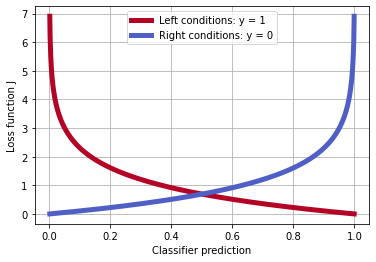

In [9]:
g = np.arange(0.001, 1.0, 0.001)

JLeft = -np.log(g)
JRight = -np.log(1 - g)

plt.plot(g, JLeft, lw=5, color='#b40426', label='Left conditions: y = 1')
plt.plot(g, JRight, lw=5, color='#505fc6', label='Right conditions: y = 0')
plt.xlabel('Classifier prediction')
plt.ylabel('Loss function J')
plt.grid(True)
plt.legend(loc='upper center')

plt.show()

The **loss** function is formed from combined limit conditions, which is plotted as a diagonal cross-section of the grid below:

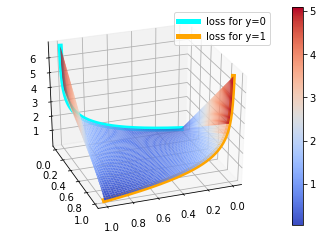

In [10]:
y = np.arange(0.001, 1.0, 0.001)

# Arguments for output equals 0
yleft = np.zeros(y.shape[0])

# Arguments for output equals 1
yright = np.ones(y.shape[0])

# Loss function
j = lambda G, Y: - Y * np.log(G) - (1 - Y) * np.log(1 - G)

# Loss function plot in 3D cross-section
ax = plot_grid(j, g, y, elev=30, azim=70)

# Loss function plot for output equals 0
ax.plot(g, yleft, j(g, yleft),
        lw=5, color='cyan', label="loss for y=0")

# Loss function plot for output equals 1
ax.plot(g, yright, j(g, yright),
        lw=5, color='orange', label="loss for y=1")

plt.legend()
plt.show()

Loss calculation test cases:

In [11]:
np.testing.assert_almost_equal(
    J(tf.constant(0.0001), tf.constant(0.0)).numpy(),
    0.00010002)

np.testing.assert_almost_equal(
    J(tf.constant(0.9998), tf.constant(1.0)).numpy(),
    0.00019999)

np.testing.assert_almost_equal(
    J(tf.constant(0.8), tf.constant(0.0)).numpy(),
    1.609438)

np.testing.assert_almost_equal(
    J(tf.constant(0.2), tf.constant(1.0)).numpy(),
    1.609438)

### Training dataset

Necessary requirements for a set of training examples are:
- Expected outputs should belong only to binary classes, e. g. $\hat{y_{j}} \in \{ 0, 1 \}$;
- Input features should be defined as rational values $ \{ x_{ij} | x_{ij} \in R \} $;

For simplicity, a set of a training examples will be generated as feed-forward of regression model $g(z_{\theta}(\hat{\theta_{i}}, x_{i, j}))$, where $ \hat{\theta_{i}} $ - **mean value** of the parameters. Also to input features is applied **normaly distributed** random noise $\varepsilon \simeq N(0, 1)$.

In [12]:
# To generate same random numbers per each run.
# Random seed definition is required for testing
# purposes, it can be commented out in experimental
# mode.
np.random.seed(0)

# Mean, variance and count of training examples
mu, sigma, n = 0.0, 1.0, 50

# Random noise
e = np.random.normal(mu, sigma, n)

# Mean value of the parameters
# NOTE: Due to random noise, the mean value does not
# necessarily equal optimal model parameters!
theta = np.array([2.0, 1.0])

# Randomly distibuted input features
x_ = np.random.uniform(low=-2.0, high=2.0, size=(2, n))

# Output labels as a direct feed-forward result
y_ = 1.0 / (1.0 + np.exp(-(theta.T @ x_)))

# Expected output labels
y = np.rint(y_)

# Input features with random noise
x = x_ + e

## Gradient descent variations

**Gradient descent** algorithms have a common feature: using calculated gradient value as a direction towards the minimum of the function. The **gradient** value, by definition, is a **vector** that points towards the direction of **the greatest increase of the function** in a specific point. So the value, opposite to the gradient value or $ - \nabla_{\theta} J $, points towards the minimum.

In general, **gradient descent** algorithm can be expressed as an iterative algorithm, that on each step $ \theta_{j}^{(i)} $ moves in direction of $ - \nabla_{\theta} J $ with a fixed size step $ \lambda $ (also known as learning rate) untill it reaches the minimum: $\theta_{j}^{(i+1)} = \theta_{j}^{(i)} - \lambda \nabla_{\theta} J$.

The well-known analogy of the algorithm in real world is a ball, rolling down the hill. In this case the gradient value $ - \nabla_{\theta} J $ representes rolling direction and learning rate $ \lambda $ - the speed.

Depending on how much data is used to compute the gradient of objective function, general form of an algorithm can variate, which leads to the possibility for a trade-off between the accuracy of the parameter update and the time it takes to perform an update.

In [13]:
# Learning rate
alpha = tf.constant(0.005)

# Start vector of parameters
theta_zero = lambda: tf.Variable([[2.0], [3.0]], trainable=True, 
                                 name="Theta", dtype=tf.float32)

# Input features
features = tf.constant(x, name="Features", dtype=tf.float32)

# Output labels
output = tf.constant(y, name="Labels", dtype=tf.float32)

### Batch gradient descent

**Batch gradient descent** or **vanilla gradient descent** performs computation of the gradient for $ \nabla_{\theta} J $ with respect to the independent variables $ \theta_{j} $ for the entire set of training examples: $\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta, x, y)$

Although **batch gradient descent** is guaranteed to converge to the global
minimum for convex noisy surfaces, it requires to calculate gradient value for the entire set training examples, which makes it unefficient to calculate in parallel and, as the result, makes it **very slow**, because it **can not update** model parameters **"on-the-fly"**. Another issue with this algorithm is an eager usage of memory, which means loading every training example into memory.

**Vanilla GD** performs redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update, so its usage is efficient on a relatively small datasets.

According to the original paper, **BGD** is guaranteed to converge to the global minimum for convex error surfaces and to a local minimum for non-convex surfaces.

In [14]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, theta: tf.Variable,
                  x: tf.constant, y: tf.constant) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, theta, x, y))

    # Feed-forward 
    z_ = tf.transpose(theta) @ x
    g_ = 1.0 / (1.0 + tf.exp(-z_))

    # Calculating loss for each training example
    j_ = J(g_, y)
    loss = tf.reduce_sum(j_) / tf.constant(n, dtype=tf.float32)

    # Gradient
    dJ_dtheta = grad.gradient(loss, theta)

  # Update parameters
  return theta - alpha * dJ_dtheta, loss

# Record loss function values for each iteration
batch_loss = np.array([])

# Record model parameters for each iteration
batch_theta = np.array([]).reshape((2, 0))

# Define start vector
theta = theta_zero()

# Iterations count
batch_epoch = 2500

for _ in range(batch_epoch):
  # Iterative descent
  theta, ji = gradient_step(alpha, theta, features, output)
  batch_loss = np.append(batch_loss, ji)
  batch_theta = np.hstack((batch_theta, theta))

print(f"Approximated theta values: {theta.numpy().flatten()}")

Approximated theta values: [ 1.3518362  -0.38995123]


### Stochastic gradient descent

Unlike algorithm from above, **stochastic gradient descent** (SGD) calculates gradient and performs parameters update **for a single training example** at once $( x_{i1}, ..., x_{in}, y_{i} ) $, where $ x_{i1}, ..., x_{in} $ are input features of a training example and $ y_{i} $ - label a training example: $\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(i)}, ..., x_{n}^{(i)}, y^{(i)})$

SGD removes redundancy for recomputing gradients for similar examples before each parameter update and also provides a possibility for a parallel computation of the gradient value for each example, which leads to updating model parameters **"on-the-fly"** (which lead to the faster computation).

Nevertheless, this approach has its own flaw: **frequent updates** with a high variance that cause the objective function to **fluctuate heavily**. On the one hand, SGD’s fluctuation enables it to jump to a new and potentially better (global) minimum in a process of descending to the other local minimum. But on the other hand, this ultimately complicates convergence to the exact minimum, as SGD will keep overshooting. In practice, this flaw can be solved using **learning rate decay methods** (e. g. rate decreasing over epoch/iteration), though it requires precise parameter tuning.

In [15]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, theta: tf.Variable,
                  x: tf.constant, y: tf.constant) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, theta, x, y))

    # Feed-forward 
    z_ = tf.transpose(theta) @ x
    g_ = 1.0 / (1.0 + tf.exp(-z_))

    # Calculating loss for each training example
    j_ = J(g_, y)

    # Gradient
    dJ_dtheta = grad.gradient(j_, theta)

  # Update parameters
  return theta - alpha * dJ_dtheta, j_

# Record loss function values for each iteration
stochatic_loss = np.array([])

# Record model parameters for each iteration
stochatic_theta = np.array([]).reshape((2, 0))

# Define start vector
theta = theta_zero()

# Iterations count
stochatic_epoch = 50

for _ in range(stochatic_epoch):
  for i in range(n):
    xi = tf.reshape(features[:, i], shape=(2, 1))
    yi = output[i]

    # Iterative descent
    theta, ji = gradient_step(alpha, theta, xi, yi)
    stochatic_loss = np.append(stochatic_loss, ji)
    stochatic_theta = np.hstack((stochatic_theta, theta))

print(f"Approximated theta values: {theta.numpy().flatten()}")

Approximated theta values: [ 1.3514132 -0.3872485]


### Mini-batch gradient descent

Mini-batch gradient descent is **the golden ratio** between BGD and SGD, because it inherits the best features from both algorithms. It performs an update **for an every subset of training examples of a fixed size** $m$:
$\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(j, j + m)}, ..., x_{n}^{(j, j + m)}, y^{(j, j + m)})$

In this approach, the variance of the parameter updates is significantly reduced, which **make converge of the algorithm more stable**.

Although, this algorithm is a combination of the best features of BGD and SGD, it's not flawless. Mini-batch GD requires precised tuning of the learning rate (if it's too small - converge speed will significantly decrease, if it's too large - the loss function will fluctuate around minimum and, as a result, it will hinder convergence) and the algorithm not effective with noisy and highly non-convex functions, so the chance of being trapped in local minimum is bigger, than in other algorithms.

As was shown in the original paper, there are other major challenges, that may occur:
 - The learning rate requires scheduling in order to make the algorithm reach the optimal point. The scheduler adjust it during training (by reducing the learning rate according to a pre-defined value or when the change in objective between epochs falls below a threshold);
 - The algorithm is not effective on sparse data (when features have different frequencies), because the same learning rate applies to all parameter updates;
 - The more saddle point function $J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)})$ have, the less effective algorithm becomes;

In [16]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, theta: tf.Variable, x: tf.constant,
                  y: tf.constant, batch_size: int) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, theta, x, y))

    # Feed-forward 
    z_ = tf.transpose(theta) @ x
    g_ = 1.0 / (1.0 + tf.exp(-z_))

    # Calculating loss for each training example
    j_ = J(g_, y)
    loss = tf.reduce_sum(j_) / tf.constant(batch_size, dtype=tf.float32)

    # Gradient
    dJ_dtheta = grad.gradient(loss, theta)

  # Update parameters
  return theta - alpha * dJ_dtheta, loss

# Record loss function values for each iteration
mini_batch_loss = np.array([])

# Record model parameters for each iteration
mini_batch_theta = np.array([]).reshape((2, 0))

# Define start vector
theta = theta_zero()

# Iterations count
mini_batch_epoch = 500

# Mini-batch size
m = 10

for _ in range(mini_batch_epoch):
  # Iterations count per epoch equals the ratio 
  # of training set size to mini-batch size
  for i in range(int(n / m)):
    xim = tf.reshape(features[:, m*i:m*(i+1)], shape=(2, m))
    yim = output[m*i:m*(i+1)]

    # Iterative descent
    theta, ji = gradient_step(alpha, theta, xim, yim, m)
    mini_batch_loss = np.append(mini_batch_loss, ji)
    mini_batch_theta = np.hstack((mini_batch_theta, theta))

print(f"Approximated theta values: {theta.numpy().flatten()}")

Approximated theta values: [ 1.3515562 -0.3898132]


**SGD's** variating descent, **BGD's** smooth descent, and **MGD's** moderate descent can be visualized on the comparison of loss function values over iterations and epochs accordingly.

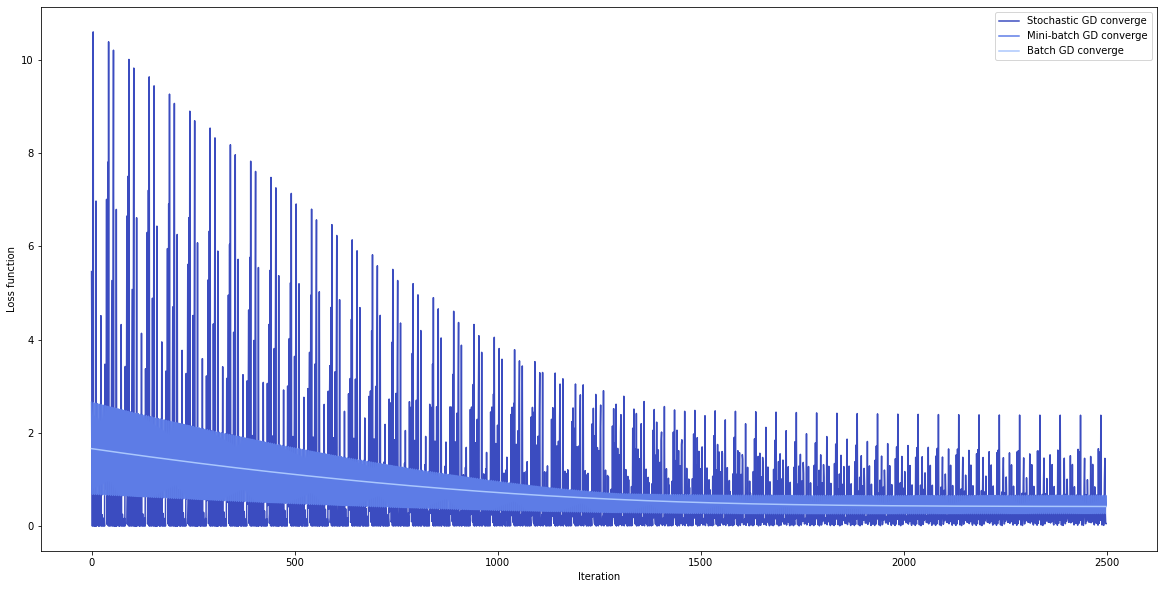

In [17]:
batch_iter = range(batch_epoch)
stochatic_iter = range(n * stochatic_epoch)
mini_batch_iter = range(int(n / m) * mini_batch_epoch)

plt.figure(figsize=(20, 10))
plt.plot(stochatic_iter, stochatic_loss,
         color='#3b4cc0', label='Stochastic GD converge')
plt.plot(mini_batch_iter, mini_batch_loss,
         color='#5d7ce6', label='Mini-batch GD converge')
plt.plot(batch_iter, batch_loss,
         color='#aac7fd', label='Batch GD converge')

plt.xlabel('Iteration')
plt.ylabel('Loss function')
plt.legend()
plt.show()

## Adaptive gradient descent methods

As was highlighted before, the common problems of the vanilla gradient descent variations are **learning rate tuning** and loss function fluctuations (for SGD and MGD). The recent researches in GD algorithms shown, that these problems can be solved and the convergence rate can be increased by using adaptive gradient calculation, which means applying gradient values from previous iterations to adjust the current one.

### Momentum

Returning back to the analogy of gradient descent algorithm as a ball, rolling down the hill, important to mention that it's not rolling with a constant speed $ \lambda $, but instead gaining speed with time by keeping the **momentum** of itself. The same approach was discovered in optimization theory: the convergence rate of an algorithm can be increased by applying a fraction $ \gamma $ of gradient from the previous iteration:

$ v_{t} = \gamma v_{t-1} + \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(i)}, ..., x_{n}^{(i)}, y^{(i)}) $

$ \theta^{(i+1)} = \theta^{(i)} - v_{t} $

The momentum term $ \gamma $ is usually set to 0.9 or a similar value.

As mentioned in previous sections, SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, which are common around the local minimum. Momentum helps accelerate SGD in the relevant direction and dampens oscillations.

In [18]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, theta: tf.Variable,
                  gamma: tf.constant, vt: tf.Variable,
                  x: tf.constant, y: tf.constant) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, theta, gamma, vt, x, y))

    # Feed-forward 
    z_ = tf.transpose(theta) @ x
    g_ = 1.0 / (1.0 + tf.exp(-z_))

    # Calculating loss for each training example
    loss = J(g_, y)

    # Gradient
    dJ_dtheta = grad.gradient(loss, theta)

    # Update vector
    v = gamma * vt + alpha * dJ_dtheta

  # Update parameters
  return theta - v, loss, v

# Record loss function values for each iteration
pure_momentum_loss = np.array([])

# Record model parameters for each iteration
pure_momentum_theta = np.array([]).reshape((2, 0))

# Define start vector
theta = theta_zero()

# Iterations count
pure_momentum_epoch = 50

# Momentum term
gamma = tf.constant(0.8)

# Start momentum vector
vt = tf.Variable([[0.0], [0.0]], name="Momentum", dtype=tf.float32)

for _ in range(pure_momentum_epoch):
  for i in range(n):
    xi = tf.reshape(features[:, i], shape=(2, 1))
    yi = output[i]

    # Iterative descent
    theta, ji, vt = gradient_step(alpha, theta, gamma, vt, xi, yi)
    pure_momentum_loss = np.append(pure_momentum_loss, ji)
    pure_momentum_theta = np.hstack((pure_momentum_theta, theta))

print(f"Approximated theta values: {theta.numpy().flatten()}")

Approximated theta values: [ 1.3969469 -0.5347274]


The acceleration effect from momentum results in stretching of the oscillations towards the minimum with every iteration, which leads to the increasing of the convergence rate.

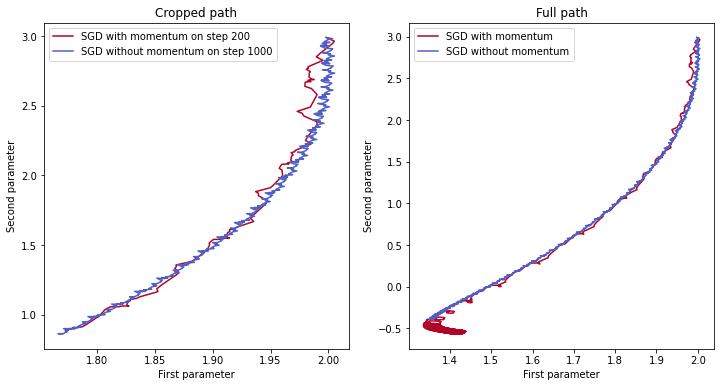

In [19]:
# Recorded descent steps
momentum_x, momentum_y = pure_momentum_theta[0], pure_momentum_theta[1]
stochatic_x, stochatic_y = stochatic_theta[0], stochatic_theta[1]

# First descent steps for each algorithm,
# to visualise oscillations stretching on small scale
momentum_steps, stochatic_steps = 200, 1000


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(momentum_x[:momentum_steps], momentum_y[:momentum_steps],
            color='#b40426',
            label=f'SGD with momentum on step {momentum_steps}')
axs[0].plot(stochatic_x[:stochatic_steps], stochatic_y[:stochatic_steps],
            color='#505fc6',
            label=f'SGD without momentum on step {stochatic_steps}')

axs[0].set_xlabel('First parameter')
axs[0].set_ylabel('Second parameter')
axs[0].set_title('Cropped path')
axs[0].legend()


axs[1].plot(momentum_x, momentum_y, color='#b40426',
            label=f'SGD with momentum')
axs[1].plot(stochatic_x, stochatic_y, color='#505fc6',
            label=f'SGD without momentum')

axs[1].set_xlabel('First parameter')
axs[1].set_ylabel('Second parameter')
axs[1].set_title('Full path')
axs[1].legend()


plt.show()

### Nesterov accelerated gradient

In this approach, the **momentum** is not only applied to the calculated gradient value on the iteration, but also to the current parameters, which gives an approximation of their next position, like a preliminary step of the algorithm:

$ v_{t} = \gamma v_{t-1} + \lambda \nabla_{\theta} J(\theta^{(i)} - \gamma v_{t-1}) $

$ \theta^{(i+1)} = \theta^{(i)} - v_{t} $

Taking the analogy from above, if a ball is made of light material, it may slope up to the other side of a hill using its **momentum**. But if it is made of heavy material (like steel), it will slow down near the bottom of the hill. The NAG algorithm work by the same principle. While **momentum** first computes the current gradient and then takes a big jump in the direction of the updated accumulated gradient, NAG first makes a big jump in the direction of the previously accumulated gradient, measures the gradient, and then makes a correction. This anticipatory update prevents us from going too fast and results in increased responsiveness (as is shown on the plot with the **momentum** algorithm above).

As was shown in the original paper, the correction of parameters on the stage of gradient calculation increase responsiveness, which has significantly increased the performance of the various neural network, like RNN.

In [20]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, theta: tf.Variable,
                  gamma: tf.constant, vt: tf.Variable,
                  x: tf.constant, y: tf.constant) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, theta, gamma, vt, x, y))

    # Feed-forward with applied momentum
    z_ = tf.transpose(theta - gamma * vt) @ x
    g_ = 1.0 / (1.0 + tf.exp(-z_))

    # Calculating loss for each training example
    loss = J(g_, y)

    # Gradient
    dJ_dtheta = grad.gradient(loss, theta)

    # Update vector
    v = gamma * vt + alpha * dJ_dtheta

  # Update parameters
  return theta - v, loss, v

# Record loss function values for each iteration
nag_loss = np.array([])

# Record model parameters for each iteration
nag_theta = np.array([]).reshape((2, 0))

# Define start vector
theta = theta_zero()

# Iterations count
nag_epoch = 50

# Momentum term
gamma = tf.constant(0.8)

# Start momentum vector
vt = tf.Variable([[0.0], [0.0]], name="Momentum", dtype=tf.float32)

for _ in range(nag_epoch):
  for i in range(n):
    xi = tf.reshape(features[:, i], shape=(2, 1))
    yi = output[i]

    # Iterative descent
    theta, ji, vt = gradient_step(alpha, theta, gamma, vt, xi, yi)
    nag_loss = np.append(nag_loss, ji)
    nag_theta = np.hstack((nag_theta, theta))

print(f"Approximated theta values: {theta.numpy().flatten()}")

Approximated theta values: [ 1.397426  -0.5338117]


## Gradient methods with adaptive learning rate

In the previous modification of **SGD**, the learning rate $ \lambda $ was fixed in size, so the problem with tuning it is still relevant to avoid either slow convergence or complete diverge. The following method modifications tend to solve this major issue.

### AdaGrad

The **AdaGrad** algorithm adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters: given learning rate $ \lambda $ value is divided on some term $ G_{i} $ that accumulates gradient values from previous iterations:

$ \theta^{(i+1)} = \theta^{(i)} - \frac{\lambda}{\sqrt{G_{i} + \epsilon}} \odot g_{i} $, where $ g_{i} = \nabla_{\theta} J(\theta^{(i)})$, $ \epsilon $ is a *smoothing term* (a small coefficient, usually equals $ 3 \cdot 10^{-6} $, that prevents the denominator from turning to zero) and  $ G_{i} $ is a combination of the previously accumulated gradient terms and element-wise product of $ g_{i} $ on itself: $ G_{i} = G_{i-1} + g_{i} \cdot g_{i} = G_{i-1} + (g_{i})^{2} $

For this reason, it is well-suited for dealing with sparse data. In the original research was shown, that the **AdaGrad** improved the robustness of **SGD**, so used it for training large-scale neural nets and NLP models (e. g. GloVe), as infrequent words require much larger updates than frequent ones.

Although the mentioned problem with tuning learning rate $ \lambda $ is solved (in practice, the value is set to default 0.01 and left like that), the new one appears: accumulation of the squared gradients in the denominator causes $ \lambda $ to shrink with every iteration (since every term is positive) and eventually is approaching zero. It can be illustrated on the given optimization problem for a small set of training examples: the learning rate $ \lambda $ should be big enough ($ \lambda $ = 0.1 for this example) to reach an area near the global minimum.

In [21]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, theta: tf.Variable,
                  vt: tf.Variable, x: tf.constant, 
                  y: tf.constant) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, theta, vt, x, y))

    # Smoothing term
    eps = tf.constant(3 * 10 ** (-8))

    # Feed-forward with applied momentum
    z_ = tf.transpose(theta) @ x
    g_ = 1.0 / (1.0 + tf.exp(-z_))

    # Calculating loss for each training example
    loss = J(g_, y)

    # Gradient
    dJ_dtheta = grad.gradient(loss, theta)

    # Gradient component
    G = vt + dJ_dtheta ** 2

    # Modified learning rate
    alpha_v = alpha / tf.sqrt(G + eps)

  # Update parameters
  return theta - alpha_v * dJ_dtheta, loss, G


# Record loss function values for each iteration
adagrad_loss = np.array([])

# Record model parameters for each iteration
adagrad_theta = np.array([]).reshape((2, 0))

# Define start vector
theta = theta_zero()

# Iterations count
adagrad_epoch = 75

# Recommended learning rate
alpha = tf.constant(0.1)

# Start momentum vector
vt = tf.Variable([[0.0], [0.0]], name="Momentum", dtype=tf.float32)

for _ in range(adagrad_epoch):
  for i in range(n):
    xi = tf.reshape(features[:, i], shape=(2, 1))
    yi = output[i]

    # Iterative descent
    theta, ji, vt = gradient_step(alpha, theta, vt, xi, yi)
    adagrad_loss = np.append(adagrad_loss, ji)
    adagrad_theta = np.hstack((adagrad_theta, theta))

print(f"Approximated theta values: {theta.numpy().flatten()}")

Approximated theta values: [ 1.2589508  -0.39579317]


### RMSProp

A serious drawback of the **AdaGrad** algorithm is and exponential decay of a learning rate $ \lambda $, due to the accumulation of the gradient values and uncontrollable growth in the denominator. On the one hand, rate decay results in reducing fluctuations in the objective function, but on the other hand, the rate becomes negligibly small after some iterations, so the algorithm may never reach the global minimum.

In the **RMSProp** (Root Mean Square Propagation) algorithm this issue is solved by using the mean value of gradients in the denominator from the previous iterations instead of constant accumulation:

$ E(g^{2})_{i} = \beta E(g^{2})_{i-1} + (1 - \beta) g_{i}^{2} $

$ \theta^{(i+1)} = \theta^{(i)} - \frac{\lambda}{\sqrt{E(g^{2})_{i} + \epsilon}} \odot g_{i} $

where $ g_{i} = \nabla_{\theta} J(\theta^{(i)})$, $ \epsilon $ is a *smoothing term*, and $ \beta $ is a *momentum term* (according to the original research, the optimal value is **0.9**)

In [22]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, beta: tf.constant,
                  theta: tf.Variable, vt: tf.Variable,
                  x: tf.constant, y: tf.constant) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, beta, theta, vt, x, y))

    # Smoothing term
    eps = tf.constant(3 * 10 ** (-8))

    # Feed-forward with applied momentum
    z_ = tf.transpose(theta) @ x
    g_ = 1.0 / (1.0 + tf.exp(-z_))

    # Calculating loss for each training example
    loss = J(g_, y)

    # Gradient
    dJ_dtheta = grad.gradient(loss, theta)

    # Gradient component
    g = beta * vt + (1 - beta) * dJ_dtheta ** 2

    # Modified learning rate
    alpha_v = alpha / tf.sqrt(g + eps)

  # Update parameters
  return theta - alpha_v * dJ_dtheta, loss, g


# Record loss function values for each iteration
rmsprop_loss = np.array([])

# Record model parameters for each iteration
rmsprop_theta = np.array([]).reshape((2, 0))

# Define start vector
theta = theta_zero()

# Iterations count
rmsprop_epoch = 20

# Recommended learning rate
alpha = tf.constant(0.01)

# Recommended momentum term
beta = tf.constant(0.9)

# Start momentum vector
vt = tf.Variable([[0.0], [0.0]], name="Momentum", dtype=tf.float32)

for _ in range(rmsprop_epoch):
  for i in range(n):
    xi = tf.reshape(features[:, i], shape=(2, 1))
    yi = output[i]

    # Iterative descent
    theta, ji, vt = gradient_step(alpha, beta, theta, vt, xi, yi)
    rmsprop_loss = np.append(rmsprop_loss, ji)
    rmsprop_theta = np.hstack((rmsprop_theta, theta))

print(f"Approximated theta values: {theta.numpy().flatten()}")

Approximated theta values: [ 1.3072461  -0.27233392]


### ADAM

The **ADAM** (Adaptive Moment Estimation) algorithm adapts not only the learning rate $ \lambda $ to the parameters (like **AdaGrad** and **RMSProp**), also keeps an exponentially decaying average of past gradients $ m_{i} $, similar to momentum:

$ m_{i} = \beta_{1} m_{i-1} + (1 - \beta_{1}) g_{i} $

$ v_{i} = \beta_{2} v_{i-1} + (1 - \beta_{2}) g_{i}^{2} $

where $ g_{i} = \nabla_{\theta} J(\theta^{(i)})$, $ m_{i} $ - mean value estimation (first moment) of the gradients respectively, $ v_{i} $ - the uncentered variance estimation (second moment) of the gradients respectively.

The original research was shown, that moment estimations are biased towards zero on the first iterations, especially when terms $ \beta_{1} $, $ \beta_{2} $ are small. So in the descent algorithm, bias-corrected estimates are used:

$ \hat{m_{i}} = \frac{m_{i}}{1 - \beta_{1}} $

$ \hat{v_{i}} = \frac{v_{i}}{1 - \beta_{2}} $

Now update rule for parameters can be modified using adaptive estimations:

$ \theta^{(i+1)} = \theta^{(i)} - \frac{\lambda}{\sqrt{\hat{v_{i}} + \epsilon}} \hat{m_{i}} $

From the empirical point of view, default estimation terms for the algorithm are equal: $ \beta_{1} = 0.9 $, $ \beta_{2} = 0.999 $.

For the given optimization problem, the approach with adaptive estimations for learning rate $ \lambda $ and for momentum will result in not only efficient convergence on the sparse data but also in adaptive decay of the momentum when the algorithm is approaching the minimum point (so the algorithm will not jump over the minimum, unlike pure momentum algorithm).

In [23]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, beta1: tf.constant, beta2: tf.constant,
                  theta: tf.Variable, vt: tf.Variable, mt: tf.Variable,
                  x: tf.constant, y: tf.constant) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, beta1, beta2, theta, vt, mt, x, y))

    # Smoothing term
    eps = tf.constant(3 * 10 ** (-8))

    # Feed-forward with applied momentum
    z_ = tf.transpose(theta) @ x
    g_ = 1.0 / (1.0 + tf.exp(-z_))

    # Calculating loss for each training example
    loss = J(g_, y)

    # Gradient
    dJ_dtheta = grad.gradient(loss, theta)

    # Estimate first moment (mean value)
    m = beta1 * mt + (1 - beta1) * dJ_dtheta

    # Gradient component
    v = beta2 * vt + (1 - beta2) * dJ_dtheta ** 2

    # Modified learning rate
    alpha_v = alpha / tf.sqrt(v + eps)

  # Update parameters
  return theta - alpha_v * m, loss, m, v


# Record loss function values for each iteration
adam_loss = np.array([])

# Record model parameters for each iteration
adam_theta = np.array([]).reshape((2, 0))

# Define start vector
theta = theta_zero()

# Iterations count
adam_epoch = 8

# Recommended learning rate
alpha = tf.constant(0.01)

# Recommended estimations terms
beta1, beta2 = tf.constant(0.9), tf.constant(0.999)

# Start mean value estimation
mt = tf.Variable([[0.0], [0.0]], name="Mean value", dtype=tf.float32)

# Start uncentered variance estimation
vt = tf.Variable([[0.0], [0.0]], name="Uncentered variance", dtype=tf.float32)

for _ in range(adam_epoch):
  for i in range(n):
    xi = tf.reshape(features[:, i], shape=(2, 1))
    yi = output[i]

    # Iterative descent
    theta, ji, mt, vt = gradient_step(alpha, beta1, beta2,
                                      theta, vt, mt, xi, yi)
    adam_loss = np.append(adam_loss, ji)
    adam_theta = np.hstack((adam_theta, theta))

print(f"Approximated theta values: {theta.numpy().flatten()}")

Approximated theta values: [ 1.2375536  -0.37260002]


## Conclusion

A comparison will be made of how close each of the algorithms approached the global minimum. The optimal values for the model were derived using the analytical algorithm in the [scikit-learn](https://github.com/scikit-learn/scikit-learn) library.

In [24]:
from sklearn.linear_model import LogisticRegression

optimal_theta = LogisticRegression(random_state=0).fit(x.T, y).coef_.flatten()

print(f"Optimal theta values: {optimal_theta}")

Optimal theta values: [ 1.23579633 -0.44917697]


The chosen metric for distance is **Root Mean Squared Error**: $RMSE = \sqrt(\sum_{i=1}^{n}(\theta_{i} - \hat{\theta}_{i})^{2})$. As can be seen on the plot, the closest algorithm is **AdaGrad**.

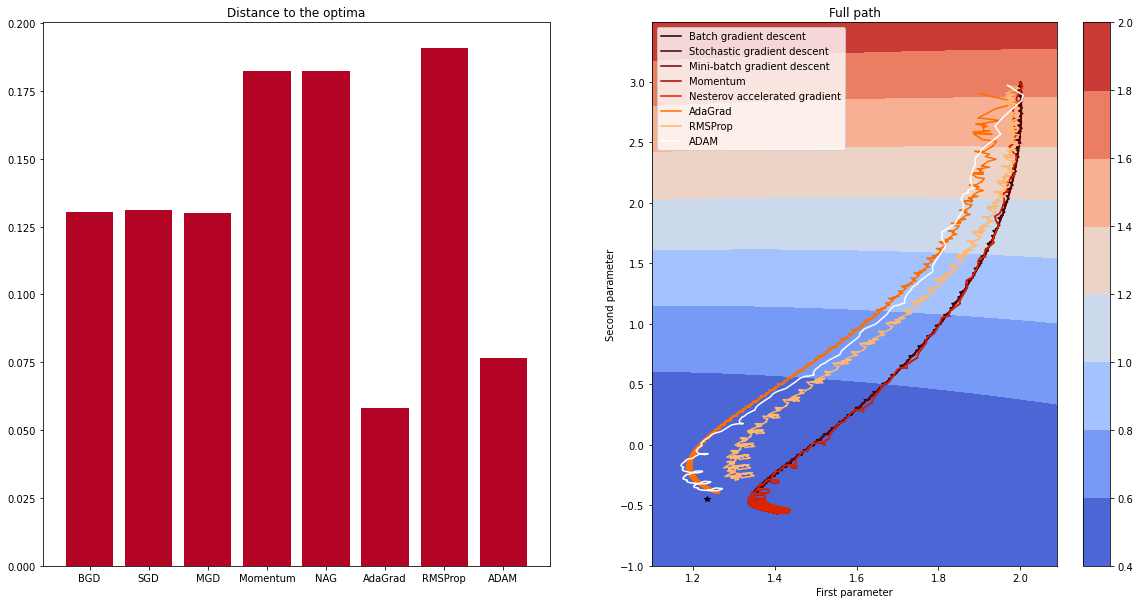

In [25]:
# Applying custom colormap to the plot
rcParams['axes.prop_cycle'] = cycler(color=plt.cm.gist_heat(np.linspace(0, 1, 8)))

# Regression loss
loss = lambda G, Y: - Y * np.log(G) - (1 - Y) * np.log(1 - G)

# Trajectory meshgrid
T1, T2 = np.meshgrid(np.arange(1.1, 2.1, 0.01), np.arange(-1.0, 3.5, 0.01))
Js = np.zeros(T1.shape)

# Calculating loss value for each parameter combination in range
for i in range(Js.shape[0]):
  for j in range(Js.shape[1]):
    g = 1.0 / (1.0 + np.exp(-(T1[i, j] * x[0] + T2[i, j] * x[1])))
    ji = loss(g, y)
    Js[i, j] = np.sum(ji) / len(ji)


# Root mean squared error of expected and actual parameters
rmse = lambda x, y: np.sqrt(np.sum(np.square(x - y)))

# Bar chart labels
labels = np.array(['BGD', 'SGD', 'MGD', 'Momentum',
                   'NAG', 'AdaGrad', 'RMSProp', 'ADAM'])

# Optimal parameters per each 
thetas = np.array([batch_theta[:, -1], stochatic_theta[:, -1],
                   mini_batch_theta[:, -1], pure_momentum_theta[:, -1],
                   nag_theta[:, -1], adagrad_theta[:, -1],
                   rmsprop_theta[:, -1], adam_theta[:, -1]])

distance = np.array([])

# Calculatimg distance for each optimal value
for theta in thetas:
  distance = np.append(distance, rmse(optimal_theta, theta))

# Recorded descent steps
batch_x, batch_y = batch_theta[0], batch_theta[1]
stochatic_x, stochatic_y = stochatic_theta[0], stochatic_theta[1]
mini_batch_x, mini_batch_y = mini_batch_theta[0], mini_batch_theta[1]
pure_momentum_x, pure_momentum_y = pure_momentum_theta[0], pure_momentum_theta[1]
nag_x, nag_y = nag_theta[0], nag_theta[1]
adagrad_x, adagrad_y = adagrad_theta[0], adagrad_theta[1]
rmsprop_x, rmsprop_y = rmsprop_theta[0], rmsprop_theta[1]
adam_x, adam_y = adam_theta[0], adam_theta[1]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# RMSE value comparison
axs[0].bar(labels, distance, color='#b40426')
axs[0].set_title('Distance to the optima')

# Descent trajectory plots
loss_contour = axs[1].contourf(T1, T2, Js, cmap=plt.cm.coolwarm)

axs[1].plot(batch_x, batch_y,
            label=f'Batch gradient descent')
axs[1].plot(stochatic_x, stochatic_y,
            label=f'Stochastic gradient descent')
axs[1].plot(mini_batch_x, mini_batch_y,
            label=f'Mini-batch gradient descent')
axs[1].plot(pure_momentum_x, pure_momentum_y,
            label=f'Momentum')
axs[1].plot(nag_x, nag_y,
            label=f'Nesterov accelerated gradient')
axs[1].plot(adagrad_x, adagrad_y,
            label=f'AdaGrad')
axs[1].plot(rmsprop_x, rmsprop_y,
            label=f'RMSProp')
axs[1].plot(adam_x, adam_y,
            label=f'ADAM')
axs[1].plot(optimal_theta[0], optimal_theta[1], marker='*')

axs[1].set_xlabel('First parameter')
axs[1].set_ylabel('Second parameter')
axs[1].set_title('Full path')
axs[1].legend()

fig.colorbar(loss_contour)

plt.show()

## Attribution

Overview is based on research paper "An overview of gradient descent optimization algorithms" from [arXiv.org](https://arxiv.org/pdf/1609.04747.pdf) by [Sebastian Ruder](mailto:ruder.sebastian@gmail.com) licensed under CC BY-NC-SA 4.0.